In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.preprocessing import LabelEncoder, FunctionTransformer, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

from lime.lime_text import LimeTextExplainer
from IPython.display import HTML, display

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Classes: ['Anxiety' 'Depression' 'Normal']
Counts:
 y
2    1019
1     800
0     798
Name: count, dtype: int64 



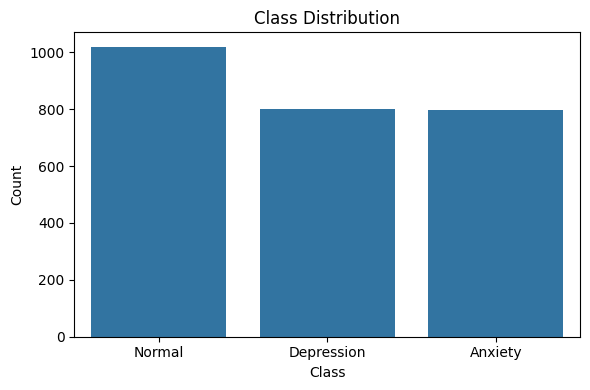

In [3]:
# Load & Label-Encode Data + Class Distribution
df = pd.read_csv("../Data/Preprocessed_Manual_Labelled_Dataset .csv")
df['text'] = (df['cleaned_text']
                .astype(str)
                .str.replace(r'\s+', ' ', regex=True)
                .str.strip())

le = LabelEncoder()
df['y'] = le.fit_transform(df['label'])

print("Classes:", le.classes_)
print("Counts:\n", df['y'].value_counts(), "\n")

plt.figure(figsize=(6,4))
sns.barplot(
    x=df['label'].value_counts().index,
    y=df['label'].value_counts().values
)
plt.title('Class Distribution')
plt.xlabel('Class'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

In [4]:
# Define Stemmer + Transformer
COMMON_SUFFIXES = [
    'වූ','වෙන','වෙයි','වුණ','න්න','නුම්',
    'වී','යේ','යුතු','පුළුවන්','කරන','කරයි',
    'හු','වරු','ලා','වල්','ගේ','ට','ගෙන්','ළඟ',
    'එක','යි','ද','ක්','ම','ටයි','තුමා'
]

def stem_and_join(text: str) -> str:
    tokens, stems = text.split(), []
    for tok in tokens:
        stem = tok
        for suf in COMMON_SUFFIXES:
            if stem.endswith(suf) and len(stem) - len(suf) >= 2:
                stem = stem[:-len(suf)]
                break
        stems.append(stem)
    return " ".join(stems)

def transform_stems(X):
    return [stem_and_join(x) for x in X]

In [5]:
# Train/Test Split
X_raw     = df['text']
X_stemmed = df['text'].map(stem_and_join)
y         = df['y']

X_tr_raw, X_te_raw, X_tr_stem, X_te_stem, y_train, y_test = train_test_split(
    X_raw, X_stemmed, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

In [6]:
# TF-IDF Settings
TFIDF_ARGS = dict(
    token_pattern=r'(?u)\b\w{3,}\b',
    ngram_range=(1,2),
    max_features=3000,
    sublinear_tf=True
)

In [7]:
# Learning-Curve Helper
def plot_learning_curve(estimator, X, y, cv=3, title="Learning Curve"):
    from sklearn.model_selection import learning_curve as lc
    tr_sizes, tr_scores, val_scores = lc(
        estimator, X, y,
        train_sizes=np.linspace(0.2,1.0,5),
        cv=cv, scoring='accuracy',
        shuffle=True, random_state=RANDOM_STATE, n_jobs=-1
    )
    plt.figure(figsize=(10,5))
    plt.plot(tr_sizes, tr_scores.mean(axis=1),'o-',label='Train')
    plt.plot(tr_sizes, val_scores.mean(axis=1),'o-',label='CV')
    plt.title(title); plt.xlabel("Training Examples"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True); plt.show()

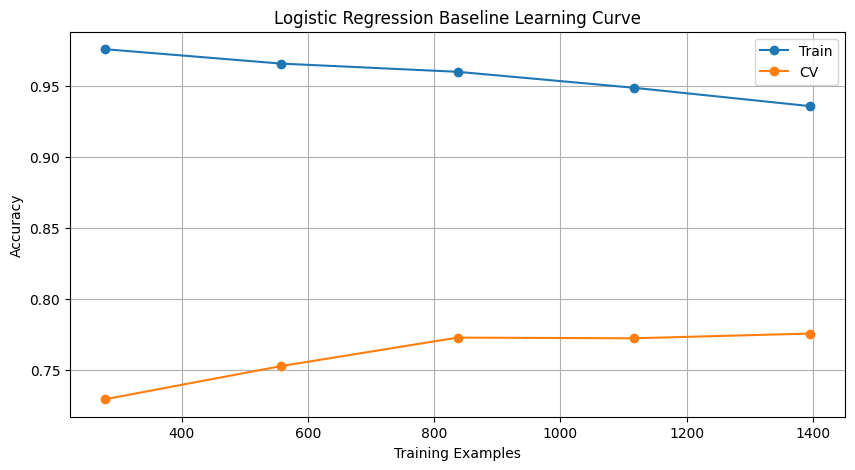

In [8]:
# Baseline LR Learning Curve
baseline_lr = Pipeline([
    ('stem',  FunctionTransformer(transform_stems, validate=False)),
    ('tfidf', TfidfVectorizer(**TFIDF_ARGS)),
    ('clf',   LogisticRegression(
                  class_weight='balanced',
                  max_iter=1000,
                  random_state=RANDOM_STATE
              ))
])
plot_learning_curve(baseline_lr, X_tr_raw, y_train, cv=3,
                    title="Logistic Regression Baseline Learning Curve")

In [9]:
# RandomizedSearchCV with SMOTE toggle
pipe = ImbPipeline([
    ('stem',  FunctionTransformer(transform_stems, validate=False)),
    ('tfidf', TfidfVectorizer(**TFIDF_ARGS)),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf',   LogisticRegression(
                  class_weight='balanced',
                  max_iter=1000,
                  random_state=RANDOM_STATE
              ))
])

param_dist = {
    'smote':               [SMOTE(random_state=RANDOM_STATE), 'passthrough'],
    'clf__C':              [0.01, 0.1, 1, 10],
    'clf__penalty':        ['l1', 'l2'],
    'clf__solver':         ['liblinear', 'saga']
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=20, cv=3,
    scoring='f1_weighted',
    n_jobs=-1, verbose=2,
    random_state=RANDOM_STATE
)
search.fit(X_tr_raw, y_train)
best_params = search.best_params_
print("Best hyperparameters:", best_params, "\n")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END clf__C=10, clf__penalty=l2, clf__solver=liblinear, smote=passthrough; total time=   0.2s
[CV] END clf__C=10, clf__penalty=l2, clf__solver=liblinear, smote=passthrough; total time=   0.2s
[CV] END clf__C=10, clf__penalty=l2, clf__solver=liblinear, smote=passthrough; total time=   0.3s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=saga, smote=passthrough; total time=   0.3s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=saga, smote=passthrough; total time=   0.3s
[CV] END clf__C=0.1, clf__penalty=l2, clf__solver=saga, smote=passthrough; total time=   0.3s
[CV] END clf__C=10, clf__penalty=l1, clf__solver=liblinear, smote=SMOTE(random_state=42); total time=   0.3s
[CV] END clf__C=1, clf__penalty=l1, clf__solver=liblinear, smote=passthrough; total time=   0.2s
[CV] END clf__C=1, clf__penalty=l1, clf__solver=liblinear, smote=passthrough; total time=   0.2s
[CV] END clf__C=1, clf__penalty=l1, clf__solver=liblinear, s

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear, smote=passthrough; total time=   0.2s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear, smote=passthrough; total time=   0.2s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=saga, smote=SMOTE(random_state=42); total time=   0.3s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=saga, smote=SMOTE(random_state=42); total time=   0.3s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=saga, smote=SMOTE(random_state=42); total time=   0.3s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=saga, smote=passthrough; total time=   0.2s
[CV] END clf__C=10, clf__penalty=l1, clf__solver=liblinear, smote=passthrough; total time=   2.2s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=saga, smote=passthrough; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=saga, smote=passthrough; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10, clf__penalty=l1, clf__solver=liblinear, smote=SMOTE(random_state=42); total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=10, clf__penalty=l1, clf__solver=saga, smote=SMOTE(random_state=42); total time=   5.9s
[CV] END clf__C=10, clf__penalty=l1, clf__solver=saga, smote=SMOTE(random_state=42); total time=   5.8s
[CV] END clf__C=10, clf__penalty=l1, clf__solver=saga, smote=SMOTE(random_state=42); total time=   5.9s
Best hyperparameters: {'smote': 'passthrough', 'clf__solver': 'saga', 'clf__penalty': 'l2', 'clf__C': 1} 



In [10]:
# Final Evaluation
best_lr = search.best_estimator_
y_pred  = best_lr.predict(X_te_raw)
y_proba = best_lr.predict_proba(X_te_raw)

acc  = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)
roc  = roc_auc_score(
    y_test, y_proba, multi_class='ovr', average='weighted'
)

print(f"Test Accuracy : {acc:.3f}")
print(f"Precision     : {prec:.3f}")
print(f"Recall        : {rec:.3f}")
print(f"F1‑Score      : {f1:.3f}")
print(f"ROC‑AUC       : {roc:.3f}\n")
print("Classification Report:\n",
      classification_report(y_test, y_pred, target_names=le.classes_))

Test Accuracy : 0.790
Precision     : 0.791
Recall        : 0.790
F1‑Score      : 0.790
ROC‑AUC       : 0.924

Classification Report:
               precision    recall  f1-score   support

     Anxiety       0.77      0.72      0.75       160
  Depression       0.75      0.80      0.77       160
      Normal       0.84      0.83      0.84       204

    accuracy                           0.79       524
   macro avg       0.79      0.79      0.79       524
weighted avg       0.79      0.79      0.79       524



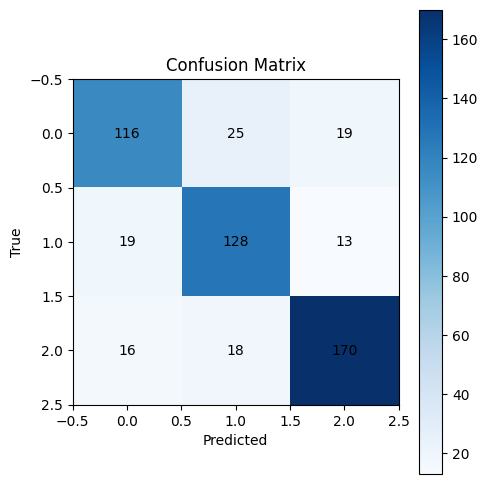

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.colorbar(); plt.tight_layout(); plt.show()

In [12]:
# LIME Explanation
lr_tuned = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    **{k.split('__')[-1]:v for k,v in best_params.items() if k.startswith('clf__')},
    random_state=RANDOM_STATE
)
full_lr_pipe = Pipeline([
    ('stem',  FunctionTransformer(transform_stems, validate=False)),
    ('tfidf', TfidfVectorizer(**TFIDF_ARGS)),
    ('clf',   lr_tuned)
])
full_lr_pipe.fit(X_tr_raw, y_train)

explainer = LimeTextExplainer(class_names=le.classes_, split_expression=r'\s+')
idx = 5
exp = explainer.explain_instance(
    X_te_raw.iloc[idx],
    full_lr_pipe.predict_proba,
    num_features=10,
    num_samples=300
)
print("\nTop contributing stems:")
for tok, wt in exp.as_list():
    print(f"  {tok:>8s} → {wt:+.4f}")
display(HTML(exp.as_html()))


Top contributing stems:
      ආදරේ → +0.2036
   අතහැරලා → +0.1611
      යනවා → +0.1239
     අසමත් → -0.0245
     විභාග → -0.0220
    කරගන්න → -0.0188
  අක්රමවත් → +0.0183
   දරාගන්න → -0.0175
   හිතෙනවා → +0.0086
    විදියට → +0.0075


In [13]:
# Save Artifacts
with open('lr_pipeline.pkl','wb') as f:
    pickle.dump(full_lr_pipe, f)
with open('label_encoder_lr.pkl','wb') as f:
    pickle.dump(le, f)
print("All artifacts saved.")

All artifacts saved.


In [14]:
# Additional Diagnostic Plots
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
probs = full_lr_pipe.predict_proba(X_te_raw)
colors = ['navy','darkorange','green']

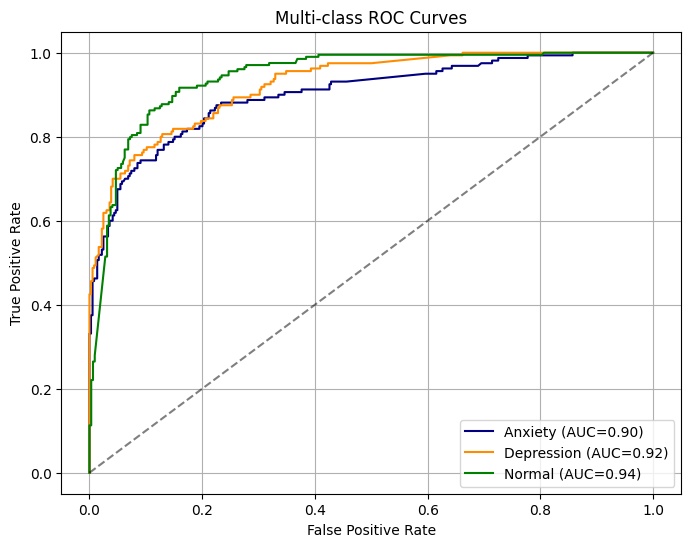

In [15]:
# Multi-class ROC Curves
plt.figure(figsize=(8,6))
for i,col in enumerate(colors):
    fpr,tpr,_ = roc_curve(y_test_bin[:,i], probs[:,i])
    plt.plot(fpr,tpr,col,label=f"{le.classes_[i]} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.title('Multi‑class ROC Curves')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(loc='lower right'); plt.grid(True); plt.show()

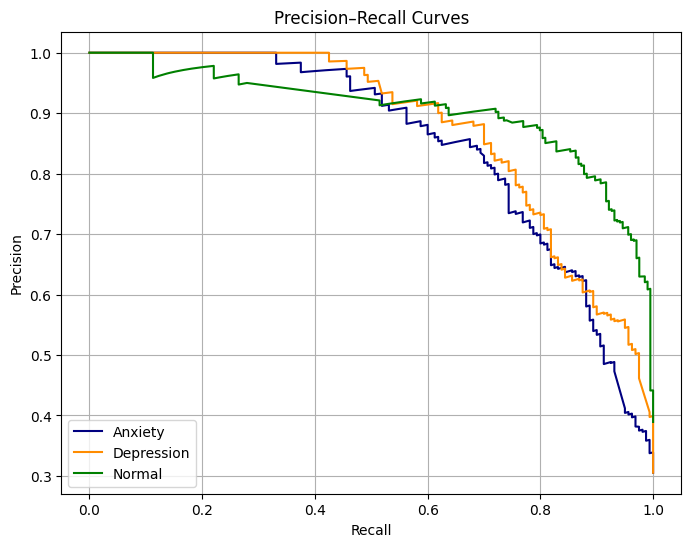

In [16]:
# Precision–Recall Curves
plt.figure(figsize=(8,6))
for i,col in enumerate(colors):
    p,r,_ = precision_recall_curve(y_test_bin[:,i], probs[:,i])
    plt.plot(r,p,col,label=le.classes_[i])
plt.title('Precision–Recall Curves')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend(loc='lower left'); plt.grid(True); plt.show()

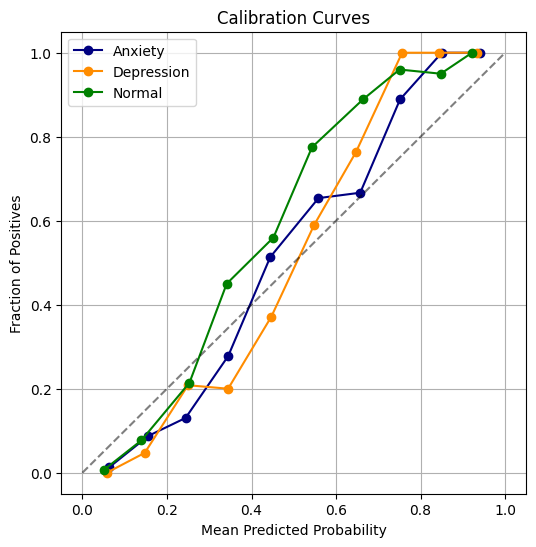

In [17]:
# Calibration Curves
plt.figure(figsize=(6,6))
for i,col in enumerate(colors):
    pt,pp = calibration_curve(y_test_bin[:,i], probs[:,i], n_bins=10)
    plt.plot(pp,pt,'o-',color=col,label=le.classes_[i])
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.title('Calibration Curves')
plt.xlabel('Mean Predicted Probability'); plt.ylabel('Fraction of Positives')
plt.legend(); plt.grid(True); plt.show()

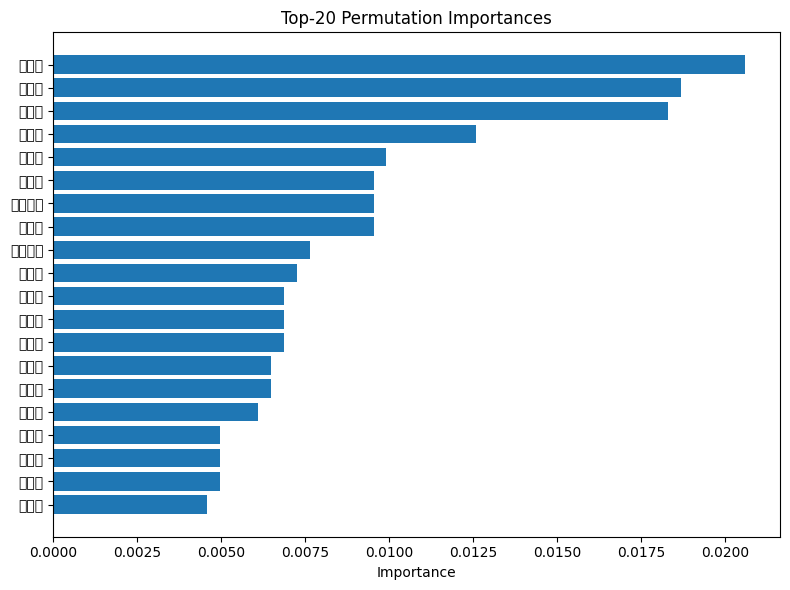

Feature # → Sinhala stem
 1: උනන
 2: යනව
 3: ඉදන
 4: නවත
 5: වයස
 6: නරක
 7: ආතත
 8: මතක
 9: ආදර
10: ලනව
11: ඩනය
12: කලබල
13: දහඩ
14: අඬනව
15: තරම
16: කවද
17: කරග
18: කණස
19: කනස
20: ටවත


In [18]:
# Top‑20 Permutation Importances
vec = full_lr_pipe.named_steps['tfidf']
X_te_dense = vec.transform(transform_stems(X_te_raw)).toarray()
perm = permutation_importance(
    full_lr_pipe.named_steps['clf'],
    X_te_dense,
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
imps       = perm.importances_mean
feat_names = vec.get_feature_names_out()
idxs       = np.argsort(imps)[-20:]

plt.figure(figsize=(8,6))
nums = np.arange(1,21)
plt.barh(nums[::-1], imps[idxs][::-1])
plt.yticks(nums[::-1], feat_names[idxs][::-1], fontsize=10)
plt.title('Top‑20 Permutation Importances')
plt.xlabel('Importance'); plt.tight_layout(); plt.show()

print("Feature # → Sinhala stem")
for num,name in zip(nums, feat_names[idxs]):
    print(f"{num:2d}: {name}")

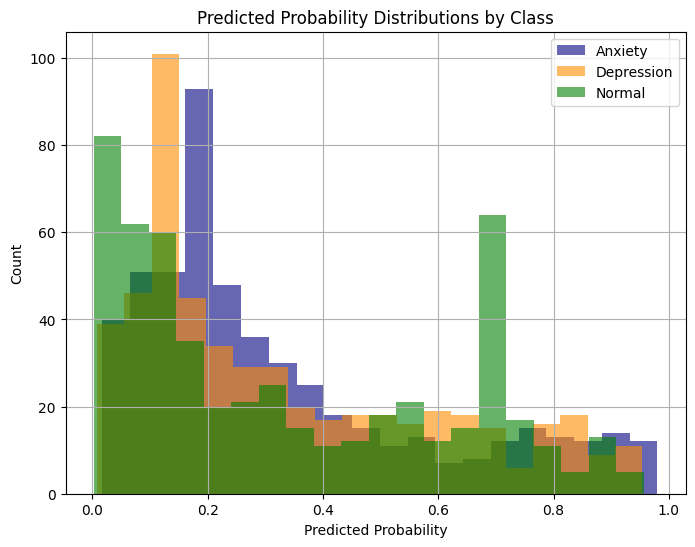

In [19]:
# Class Probability Histograms
plt.figure(figsize=(8,6))
for i,col in enumerate(colors):
    plt.hist(probs[:,i], bins=20, alpha=0.6, label=le.classes_[i], color=col)
plt.title('Predicted Probability Distributions by Class')
plt.xlabel('Predicted Probability'); plt.ylabel('Count')
plt.legend(); plt.grid(True); plt.show()